## Introduction 

In this notebook we will go through basics of Convolutional neural nets for NLP. We follow the book "Natural Language Processing in Action" by H. Lane, C. Howard, H.M. Hapke

"Language’s true power isn’t in the words themselves, but in the spaces between the words, in the order and combination of words. Sometimes meaning is hidden beneath the words, in the intent and emotion that formed that particular combination of words."

Basic feedforward networks are capable of pulling patterns out of data. But, the patterns they discover are found by relating weights to pieces of the input. Nothing captures the relations of the tokens. The one of most important neural network architectures for natural language processing is convolutional neural nets. It captures the relations of the tokens spatially.



In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import glob
import re
import tqdm

import requests
from pugnlp.futil import path_status, find_files

import os

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')


In [2]:
#%pip install pugnlp

In [3]:
from sklearn.utils import shuffle

def pre_process_data(filepath):
    dataset = []
    
    true=pd.read_csv(os.path.join(filepath, 'True.csv'))
    true['target']=0
    fake=pd.read_csv(os.path.join(filepath, 'Fake.csv'))
    fake['target']=1
    
    dataset=pd.concat([true,fake],join='outer',axis=0)
    dataset=shuffle(dataset, random_state=42)
    dataset=dataset.reset_index(drop=True)
        
    return dataset

In [4]:
dataset = pre_process_data('/Users/taronzakaryan/input/fake_and_real_news_dataset')

In [5]:
dataset.head()

,title,text,subject,date,target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


The next step is to tokenize and vectorize the data. We will use the Google News prettained Word2vec vectors, so download those via the nlpia package or directly from Google.

In [6]:
# From the nlpia package for downloading data too big for the repo

BIG_URLS = {
    'w2v': (
        'https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1',
        1647046227,
    ),
}

In [7]:
# These functions are part of the nlpia package which can be pip installed and run from there.
def dropbox_basename(url):
    filename = os.path.basename(url)
    match = re.findall(r'\?dl=[0-9]$', filename)
    if match:
        return filename[:-len(match[0])]
    return filename

def download_file(url, data_path='.', filename=None, size=None, chunk_size=4096, verbose=True):
    """Uses stream=True and a reasonable chunk size to be able to download large (GB) files over https"""
    if filename is None:
        filename = dropbox_basename(url)
    file_path = os.path.join(data_path, filename)
    if url.endswith('?dl=0'):
        url = url[:-1] + '1'  # noninteractive download
    if verbose:
        tqdm_prog = tqdm
        print('requesting URL: {}'.format(url))
    else:
        tqdm_prog = no_tqdm
    r = requests.get(url, stream=True, allow_redirects=True)
    size = r.headers.get('Content-Length', None) if size is None else size
    print('remote size: {}'.format(size))

    stat = path_status(file_path)
    print('local size: {}'.format(stat.get('size', None)))
    if stat['type'] == 'file' and stat['size'] == size:  # TODO: check md5 or get the right size of remote file
        r.close()
        return file_path

    print('Downloading to {}'.format(file_path))

    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:  # filter out keep-alive chunks
                f.write(chunk)

    r.close()
    return file_path


In [8]:
download_file(BIG_URLS['w2v'][0])

requesting URL: https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1
remote size: 1647046227
local size: 1647046227


'./GoogleNews-vectors-negative300.bin.gz'

In [9]:
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
#from nlpia.loaders import get_data
#word_vectors = get_data('w2v', limit=200000)
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=200000)

maxlen = 400

def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for i in range(len(dataset)):
        tokens = tokenizer.tokenize(dataset.iloc[i,1])+tokenizer.tokenize(dataset.iloc[i,0])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])

            except KeyError:
                pass  # No matching token in the Google w2v vocab
            
        vectorized_data.append(sample_vecs)

    return vectorized_data

In our implementations of CNN, we want that the input have fixed length to pass into a feed forward layer for classification. A fixed length vector representation of an object is called an embedding. So that the thought vector is of consistent size, you have to unroll the net to a consistent number of time steps (tokens).

In [10]:
vectorized_data = tokenize_and_vectorize(dataset)

In [11]:
split_point = int(len(vectorized_data)*.8)

x_train = vectorized_data[:split_point]
y_train = dataset['target'][:split_point]
x_test = vectorized_data[split_point:]
y_test = dataset['target'][split_point:]

In [12]:
maxlen = 400
batch_size = 32         # How many samples to show the net before backpropogating the error and updating the weights
embedding_dims = 300    # Length of the token vectors we will create for passing into the Convnet
filters = 250           # Number of filters we will train
kernel_size = 3         # The width of the filters, actual filters will each be a matrix of weights of size: embedding_dims x kernel_size or 300 x 3 in our case
hidden_dims = 250       # Number of neurons in the plain feed forward net at the end of the chain
epochs = 2              # Number of times we will pass the entire training dataset through the network

In [13]:
# Must manually pad/truncate

def pad_trunc(data, maxlen):
    """ For a given dataset pad with zero vectors or truncate to maxlen """
    new_data = []

    # Create a vector of 0's the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)

    for sample in data:
 
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

We can’t feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:
* Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors (the Embedding layer, which we’ll cover in detail later in the book).
* One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vec- tor that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

In [14]:
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

In [15]:
np.shape(x_train)

(35918, 400, 300)

In [16]:
print('Build model...')
model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1,
                 input_shape=(maxlen, embedding_dims)))
# we use max pooling:
model.add(GlobalMaxPooling1D())
# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
model_structure = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights("cnn_weights.h5")
print('Model saved.')

Build model...
Train on 35918 samples, validate on 8980 samples
Epoch 1/2
35918/35918 [==============================] - 568s 16ms/step - loss: 0.0193 - accuracy: 0.9922 - val_loss: 0.0021 - val_accuracy: 0.9991
Epoch 2/2
35918/35918 [==============================] - 546s 15ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0058 - val_accuracy: 0.9987
Model saved.


In [17]:
from keras.models import model_from_json
with open("cnn_model.json", "r") as json_file:
    json_string = json_file.read()
model = model_from_json(json_string)

model.load_weights('cnn_weights.h5')

In [18]:
pred = model.predict_classes(x_test)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [19]:
print(classification_report(y_test, pred, target_names=['Fake','True']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4345
    Not Fake       1.00      1.00      1.00      4635

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [20]:
cm=confusion_matrix(y_test, pred)

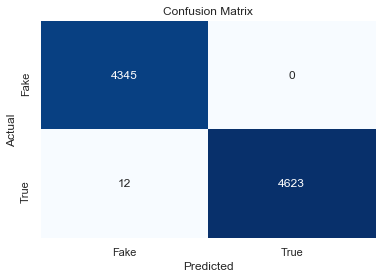

In [21]:
plt.title("Confusion Matrix")
sns.heatmap(cm, xticklabels=['Fake','True'], 
                yticklabels=['Fake','True'], 
                annot=True, cmap="Blues", 
                fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
print('(AUC) score for CNN Classifier: {:.4f}'.format(roc_auc_score(y_test, pred)))

(AUC) score for CNN Classifier: 0.9987
